In [1]:
import json
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

json_file_base = 'MTR_wo_poses_8a100_single.json'
json_file_att = 'MTR_MLP_Attention_8a100_single.json'

with open(json_file_base) as f:
    data_base = json.load(f)
with open(json_file_att) as f:
    data_att = json.load(f)
print(len(data_base), len(data_att))

txt_file_base = 'MTR_wo_poses_8a100_single.txt'
txt_file_att = 'MTR_MLP_Attention_8a100_single.txt'

scenario_ids_base = []
scenario_ids_att = []


with open (txt_file_base, 'r') as f:
    for line in f:
        scenario_ids_base.append(line.strip())
with open (txt_file_att, 'r') as f:
    for line in f:
        scenario_ids_att.append(line.strip())

print(len(scenario_ids_base), len(scenario_ids_att))

35012 35012
35012 35012


  0%|          | 0/35012 [00:00<?, ?it/s]

100%|██████████| 35012/35012 [00:00<00:00, 594762.29it/s]

6845
7929


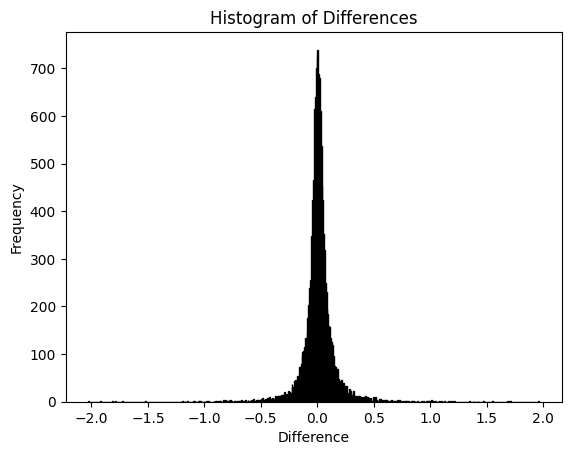

[1.96566233 1.71277794 1.70301882 1.70126344 1.6807121  1.55339309
 1.47611966 1.42361216 1.38954742 1.35449758 1.21601555 1.19555116
 1.18345522 1.16233908 1.1311818  1.12369809 1.09786065 1.08304958
 1.07835622 1.05291984]
['605c519944f01baf' 'c57d95baaacc70cd' 'd2ac02be54fcbbda'
 '26f04b1e714986cc' '5870c78395fbaf7d' '764a92ef23ac8e28'
 'fb5cd320754c7361' 'c47c6b364c8cf947' 'e42ece525fff6050'
 '54e7ee570dcd34e7' 'a4e1a96c2b311cef' 'bf600888a4845af5'
 '5c48452fa9741727' 'ef5934a076e24939' '1f70481472b7def'
 'c8eab21dca6f51c9' 'b6882ea3c063150a' 'd59a8c97c0980d2a'
 'a5ccf095e6bac84e' '72fb1eabaf94928f']
Yes
(array([11]),)


In [2]:
#diff_mlp_ade_ped = list()
diff_att_ade_ped = []
#diff_mlp_ade_cyc = list()
diff_att_ade_cyc = []
#diff_mlp_fde_ped = list()
diff_att_fde_ped = []
#diff_mlp_fde_cyc = list()
diff_att_fde_cyc = []
key_list = []
metrics = ["minADE - PEDESTRIAN", "minADE - CYCLIST", "minFDE - PEDESTRIAN", "minFDE - CYCLIST"]
lists = [diff_att_ade_ped, diff_att_ade_cyc, diff_att_fde_ped, diff_att_fde_cyc]
data_base = {key: value for d in data_base for key, value in d.items()}
data_att = {key: value for d in data_att for key, value in d.items()}
for key in tqdm(list(data_base.keys())):
    if key not in data_att.keys():
        continue
    key_list.append(key)
    for metric, single_list in zip(metrics, lists):
        if data_base[key][metric] > 0.0:
            single_list.append(data_base[key][metric] - data_att[key][metric])
        else:
            single_list.append(-np.inf)

paired_lists = sorted(zip(lists[0], key_list), key=lambda x: x[0], reverse=True)
    
# Unzip the paired list into two lists
ade_diff_ped_att, key_list = zip(*paired_lists)
count_below_zero = len(list(filter(lambda x: x < 0, np.array(ade_diff_ped_att)[np.isfinite(np.array(ade_diff_ped_att))])))
count_above_zero = len(list(filter(lambda x: x > 0, np.array(ade_diff_ped_att)[np.isfinite(np.array(ade_diff_ped_att))])))
print(count_below_zero)
print(count_above_zero)
plt.hist(np.array(ade_diff_ped_att)[np.isfinite(np.array(ade_diff_ped_att))], bins='auto', edgecolor='black')

# Adding titles and labels
plt.title('Histogram of Differences')
plt.xlabel('Difference')
plt.ylabel('Frequency')

# Show the plot
plt.show()
diff_array = np.array(ade_diff_ped_att)[np.isfinite(np.array(ade_diff_ped_att))]
index_array = np.array(key_list)[np.isfinite(np.array(ade_diff_ped_att))]
print(diff_array[:20])
print(index_array[:20])
if 'bf600888a4845af5' in index_array:
    print("Yes")
print(np.where(index_array == 'bf600888a4845af5'))


In [3]:
print(data_base['605c519944f01baf']["minADE - PEDESTRIAN"])
print(data_att['605c519944f01baf']["minADE - PEDESTRIAN"])

2.71210777759552
0.7464454447229704


In [1]:
import plotly.graph_objects as go
import glob
import os
import pickle
from waymo_open_dataset.utils import keypoint_draw, frame_utils
from waymo_open_dataset.utils.keypoint_draw import Wireframe
import numpy as np
from plotly.subplots import make_subplots
import math

example_file = '/home/erik/raid/datasets/womd/processed_scenarios_validation/sample_' + '72fb1eabaf94928f' + '.pkl'
#print(example_file)
with open(example_file, 'rb') as f:
    example = pickle.load(f)
index = np.array(example['track_infos']['object_id'])
types = np.array(example['track_infos']['object_type'])
print(index[types == 'TYPE_PEDESTRIAN'])
print(types[types == 'TYPE_PEDESTRIAN'])
print(example['tracks_to_predict'])
print(index[52])



2024-06-04 07:39:48.789423: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-04 07:39:48.843225: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-04 07:39:49.118895: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: “/usr/local/cuda-12.0/lib64:/usr/local/lib/:/opt/ros/humble/opt/rviz_ogre_vendor/lib:/opt/ros/humb

[6018 6019 6024]
['TYPE_PEDESTRIAN' 'TYPE_PEDESTRIAN' 'TYPE_PEDESTRIAN']
{'track_index': [2, 52, 16, 68], 'difficulty': [1, 1, 1, 1], 'object_type': ['TYPE_VEHICLE', 'TYPE_PEDESTRIAN', 'TYPE_VEHICLE', 'TYPE_VEHICLE']}
6019


In [2]:
def draw_skeleton(joints, lines, fig):
    for line in lines:
        if line == 0:
            connection_point = (joints[lines[line][0]] + joints[lines[line][1]]) / 2
            fig.add_trace(go.Scatter3d(x=[joints[line][0], connection_point[0]], y=[joints[line][1], connection_point[1]], z=[joints[line][2], connection_point[2]], mode='lines', line=dict(color='black', width=2)))
        else:
            for point in lines[line]:
                fig.add_trace(go.Scatter3d(x=[joints[line][0], joints[point][0]], y=[joints[line][1], joints[point][1]], z=[joints[line][2], joints[point][2]], mode='lines', line=dict(color='black', width=2)))

In [4]:
JOINT_NAMES = ["NOSE", "LEFT_SHOULDER", "LEFT_ELBOW",
               "LEFT_WRIST", "LEFT_HIP", "LEFT_KNEE",
               "LEFT_ANKLE", "RIGHT_SHOULDER", "RIGHT_ELBOW",
               "RIGHT_WRIST", "RIGHT_HIP", "RIGHT_KNEE", "RIGHT_ANKLE"]
lines = {0: [1, 7], 1: [2, 4, 7], 2: [3], 4: [5, 10], 5: [6], 7: [8, 10], 8:[9], 10:[11], 11: [12]}
path_to_womd = '/home/erik/raid/datasets/womd/'
key = 'bf600888a4845af5' #bf600888a4845af5 (3200), 26f04b1e714986cc (961), a4e1a96c2b311cef (684), 1f70481472b7def (1551, 1554), 47f813ad7de048b8 (88)
# worse: b4185172f4b58e1e (3215, 3219), 'eee4e66d49effa40' (2921), 44cc881711a0fd61 (5097), 882f19642c40c26e (1382), 9dab77dab109c445 (4745), 82185d5b99d23949 (1636), f2d17088c55320dc (2632), 819d4b9bde5ee8fd (918), 516d6ea14231945e (4233), faca92f54f0318cb (2206)
# better: 605c519944f01baf (5184), c57d95baaacc70cd (2341), d2ac02be54fcbbda (1816), 26f04b1e714986cc (961), 5870c78395fbaf7d (1927), 764a92ef23ac8e28 (1434), fb5cd320754c7361 (2655), c47c6b364c8cf947 (3261), e42ece525fff6050 (965), 54e7ee570dcd34e7 (3255), 5c48452fa9741727 (823), ef5934a076e24939 (2375), c8eab21dca6f51c9 (1107), b6882ea3c063150a (6370, 6433), d59a8c97c0980d2a (5872, 5889), a4e1a96c2b311cef (684), a5ccf095e6bac84e (5898), 72fb1eabaf94928f (6019)
obj_id = 3200
path = os.path.join(path_to_womd, 'lidar_snippets', key)
#print(path)
snippets = sorted(glob.glob(os.path.join(path, str(obj_id) + '_*')))
example_file = '/home/erik/raid/datasets/womd/processed_scenarios_validation/sample_' + key + '.pkl'
#print(example_file)
with open(example_file, 'rb') as f:
    example = pickle.load(f)
#print(example['track_infos']['object_id'])
index = example['track_infos']['object_id'].index(obj_id)
pos = example['track_infos']['trajs'][index, :, :3]
orientation = example['track_infos']['trajs'][index, :, 6]
pose_path = os.path.join(path_to_womd, 'poses', key, 'pose_data.npy')
#print(pose_path)
pose_file = np.load(pose_path)
#print(pose_file[index])
plot = {0: (1, 1), 1: (2, 1), 2: (3, 1), 3: (4, 1), 4: (5, 1), 5: (6, 1), 6: (7, 1), 7: (8, 1), 8: (9, 1), 9: (10, 1), 10: (11, 1)} 
fig = make_subplots(
    rows=11, 
    cols=1,
    start_cell="top-left", 
    specs=[
        [{"type": "scatter3d"}], 
        [{"type": "scatter3d"}],
        [{"type": "scatter3d"}],
        [{"type": "scatter3d"}],
        [{"type": "scatter3d"}],
        [{"type": "scatter3d"}],
        [{"type": "scatter3d"}],
        [{"type": "scatter3d"}],
        [{"type": "scatter3d"}],
        [{"type": "scatter3d"}],
        [{"type": "scatter3d"}]

    ]
)
for i, snippet in enumerate(snippets):
    fig = go.Figure()
    fig.update_layout(scene=dict(aspectmode='manual',
                                 aspectratio=dict(x=3, y=3, z=3),
                                 xaxis=dict(range=[-1.5, 1.5]),
                                 yaxis=dict(range=[-1.5, 1.5]),
                                 zaxis=dict(range=[-1.5, 1.5])))
    #row, col = plot[i]
    snippet = np.load(snippet)
    snippet = snippet - pos[i]
    fig.add_trace(go.Scatter3d(x=snippet[:,0], y=snippet[:,1], z=snippet[:,2], mode='markers', marker=dict(size=2, opacity=0.8)))
    fig.add_trace(go.Scatter3d(x=pose_file[index, i, :, 0], y=pose_file[index, i, :, 1], z=pose_file[index, i, :, 2], mode='markers', marker=dict(size=4, opacity=0.8, color='red')))
    draw_skeleton(pose_file[index, i], lines, fig)
    # Draw orientation line
    fig.add_trace(go.Scatter3d(x=[0, math.cos(orientation[i])], y=[0, math.sin(orientation[i])], z=[0, 0], mode='lines', line=dict(color='blue', width=2)))
    #go.Scatter3d(x=pose_file[index, i, :, 0], y=pose_file[index, i, :, 1], z=pose_file[index, i, :, 2], mode='markers', marker=dict(size=2, opacity=0.8, color='red'))
    fig.write_image('poses_plots/' + str(obj_id) + '_' + str(i) + '.png')
    fig.show()